# trackingML: DL with GlueX Fall 2018 data

This is an attempt to develop a deep learning model that can fit tracks from run 51727 from the Fall 2018 GlueX data set. The heavy lifting will be done on the GPU nodes, but initial data viewing and development done here for convenience.

In [20]:
import pandas as pd
import numpy as np

TRAIN_FILE  = '/home/davidl/work2/2020.04.30.trackingML/trackingML_features.csv'
LABELS_FILE = '/home/davidl/work2/2020.04.30.trackingML/trackingML_labels.csv'

# NOTE: Only reading first few rows for now since it takes a long time to read entire file
df       = pd.read_csv(TRAIN_FILE  , nrows=10000)
labelsdf = pd.read_csv(LABELS_FILE , nrows=10000)
print('Number of tracks: %d' % len(df.index))

df.head()

Number of tracks: 10000


,event,t_start_cntr,t_start_cntr_valid,t_tof,t_tof_valid,t_bcal,t_bcal_valid,t_fcal,t_fcal_valid,CDC_ring1_straw1,...,FDC_layer24_wire87,FDC_layer24_wire88,FDC_layer24_wire89,FDC_layer24_wire90,FDC_layer24_wire91,FDC_layer24_wire92,FDC_layer24_wire93,FDC_layer24_wire94,FDC_layer24_wire95,FDC_layer24_wire96
0,29,1000.0,0,5.94568,1,1000.0,0,1000.0,0,1000.0,...,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000,1000.0,1000.0,1000.0
1,29,1000.0,0,1000.00000,0,1000.0,0,1000.0,0,1000.0,...,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000,1000.0,1000.0,1000.0
2,25,1000.0,0,1.45875,1,1000.0,0,1000.0,0,1000.0,...,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000,1000.0,1000.0,1000.0
3,33,1000.0,0,1000.00000,0,1000.0,0,1000.0,0,1000.0,...,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000,1000.0,1000.0,1000.0
4,33,1000.0,0,5.55559,1,1000.0,0,1000.0,0,1000.0,...,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000,1000.0,1000.0,1000.0


## Print two tracks
Here we print the column names for two of the tracks just so we can see they are reasonable in regards to the wire grouping.

In [21]:
# Get first row (i.e track) of df
row = df.iloc[[0]]

# Replace all values of "1000" with NaN
row = row[row!=1000]

# Drop all columns that have a NaN
row = row.dropna(axis=1)

# Print the column names indicating the wires hit for this track
print(row.columns)

# Same as above but for different track and more compact
row = df.iloc[[200]]
print(row[row!=1000].dropna(axis=1).columns)

Index(['event', 't_start_cntr_valid', 't_tof', 't_tof_valid', 't_bcal_valid',
       't_fcal_valid', 'CDC_ring1_straw7', 'CDC_ring3_straw9',
       'CDC_ring4_straw9', 'CDC_ring5_straw20', 'CDC_ring6_straw21',
       'CDC_ring6_straw22', 'FDC_layer3_wire73', 'FDC_layer4_wire56',
       'FDC_layer5_wire31', 'FDC_layer6_wire23', 'FDC_layer7_wire49',
       'FDC_layer8_wire79', 'FDC_layer9_wire78', 'FDC_layer10_wire46',
       'FDC_layer10_wire47', 'FDC_layer12_wire19', 'FDC_layer13_wire63',
       'FDC_layer16_wire32', 'FDC_layer17_wire6', 'FDC_layer18_wire24',
       'FDC_layer19_wire73', 'FDC_layer20_wire92', 'FDC_layer21_wire67',
       'FDC_layer22_wire23', 'FDC_layer23_wire5', 'FDC_layer24_wire31'],
      dtype='object')
Index(['event', 't_start_cntr_valid', 't_tof_valid', 't_bcal_valid',
       't_fcal_valid', 'CDC_ring1_straw3', 'CDC_ring2_straw3',
       'CDC_ring3_straw4', 'CDC_ring4_straw4', 'CDC_ring5_straw12',
       'CDC_ring6_straw13', 'CDC_ring7_straw15', 'CDC_ring8_straw1

# Labels distributions

Here we plot some of the values from the labels file. We start with the state vector which has the values:

$\frac{q}{p_t}$, $\phi$, $D$, $tanl$, and $z$

where $tanl$ is the tangent of the "dip" angle or $tan(90^{\circ}-\theta)$

These should look reasonble. Checking them makes sure there is not misalignment with the values in the labels file.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fa99c18c630>],
      dtype=object)

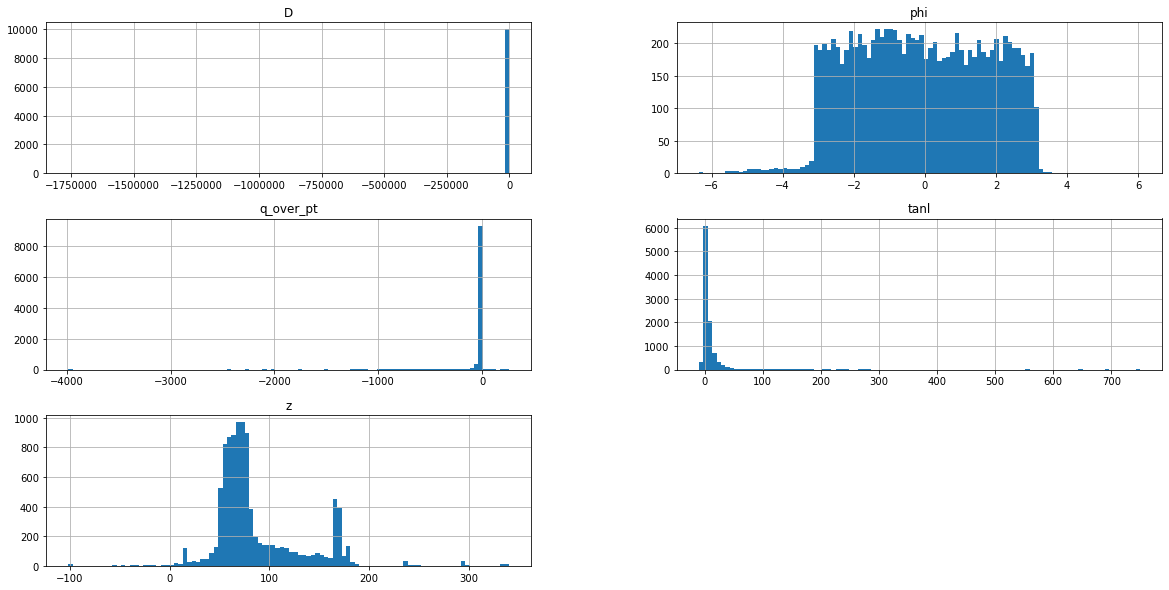

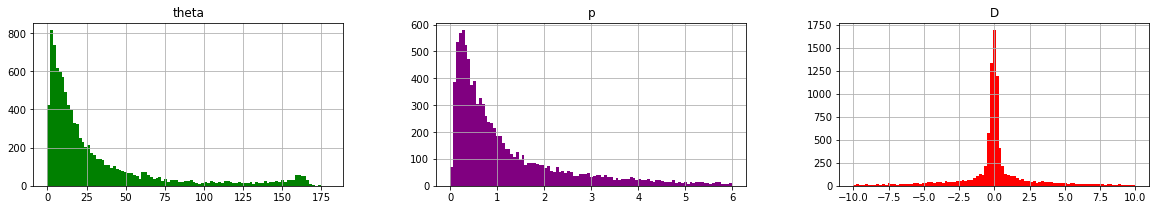

In [22]:
import matplotlib.pyplot as plt

# Plot all values from state vector
h = labelsdf.hist(column=['q_over_pt','phi','D', 'tanl', 'z'], bins=100, figsize=(20.0,10.0))

# Convert the dip angle and q_over_pt into theta and p and plot those as well
theta = np.rad2deg(np.pi/2.0-np.arctan(labelsdf['tanl']))
dftheta = pd.DataFrame(data=theta).rename(columns={'tanl':'theta'})

pmag = -1.0/labelsdf['q_over_pt']/np.sin(np.deg2rad(theta))
dfpmag = pd.DataFrame(data=pmag).rename(columns={0:'p'})

fig, ax = plt.subplots(1,3, figsize=(20,3))
dftheta.hist(ax=ax[0], column=['theta'], bins=np.linspace(0.0, 180.0, 100), color='green')
dfpmag.hist(ax=ax[1], bins=np.linspace(0.0, 6.0, 100), color='purple')
labelsdf.hist(ax=ax[2], column=['D'],bins=np.linspace(-10.0, 10.0, 100), color='red')

### Uh-oh!
So the plots look more or less reasonable. The first thing I notice though is that there is a tail in the $\phi$ distribution that goes below $-\pi$. This may indicate a problem. I also notice that $D$ is symmetric about zero with lots of negative numbers. I thought $D$ represented the $DOCA$ (=Distance Of Closest Approach) to the beam line which would make it positive definite. This may be a problem, or just a misunderstanding on my part.

To track these down, I need to find some of the offending event numbers. (I knew there would be a good reason to include the event numbers!) Below I make a list of these and then print the values for the first one, but converted to a form that matches what is printed from the hd_dump utility in GlueX. This will let me confim I'm looking at the right track and have the correct numbers.

When I do this and compare to the output of hd_dump, I can see that the values match up, except for x,y, and $\phi$. The value of $\phi$ printed there though looks to just be shifted by $2\pi$ from what is shown here which probably means the value from the state vector has just not been forced into the $-\pi<\phi<\pi$ range. Thus it is probably OK. It does raise a question though of whether we should force that into range before training, ...?

The x and y values here don't match up exactly and I realize now that how I'm calculating them is incorrect. See below for more details.

In [23]:
# Select tracks with bad phi values
baddf = labelsdf[labelsdf['phi']<-np.pi]

# Convert into x,y,p,theta to make it easier to compare to what hd_dump prints
event = baddf.iloc[[0]]['event']
q_over_pt = baddf.iloc[[0]]['q_over_pt']
tanl = baddf.iloc[[0]]['tanl']
D = baddf.iloc[[0]]['D']
phi = baddf.iloc[[0]]['phi']
z = baddf.iloc[[0]]['z']

x = D*np.cos(phi)
y = D*np.sin(phi)
theta = np.rad2deg(np.pi/2.0-np.arctan(baddf.iloc[[0]]['tanl']))
p = -1.0/q_over_pt/np.sin(np.deg2rad(theta))
phi_shifted = np.rad2deg(phi + 2.0*np.pi) # n.b. do this before converting phi to degrees!
phi = np.rad2deg(phi)

print('\n event %d: x=%f  y=%f z=%f p=%f theta=%f phi=%f phi_shifted=%f\n' % (event, x,y,z,p,theta,phi, phi_shifted))

baddf.head()


 event 76: x=10.190670  y=-2.112871 z=167.680000 p=0.380735 theta=165.521366 phi=-191.713397 phi_shifted=168.286603



,event,q_over_pt,phi,tanl,D,z,cov_00,cov_01,cov_02,cov_03,...,cov_13,cov_14,cov_22,cov_23,cov_24,cov_33,cov_34,cov_44,chisq,Ndof
31,76,-10.50520,-3.34603,-3.872670,-10.407400,167.6800,0.276198,0.000786,0.113564,-0.023070,...,-0.000332,0.002547,0.058944,-0.010479,-0.059451,0.003205,0.003629,1.03030,36.82480,2
198,185,-7.56953,-4.53779,0.539022,0.798042,58.4777,0.059209,0.005723,-0.005466,-0.078670,...,-0.015946,0.002682,0.001899,0.000668,-0.036656,0.228398,-0.071483,1.33238,13.46490,13
201,201,-9.48625,-3.47597,-3.460640,-3.113650,167.6800,0.109747,0.002810,0.033092,-0.026639,...,-0.011911,0.007930,0.020275,0.020585,-0.064834,0.169171,-0.098894,1.02514,13.27190,3
381,301,-9.97058,-4.10020,0.663135,5.371930,135.2610,0.210370,0.007189,-0.030794,-0.099540,...,-0.019835,-0.002884,0.006598,0.003561,-0.123747,0.249342,-0.153112,3.63999,6.05815,3
442,443,-9.47224,-3.43126,-0.469452,4.078260,97.7567,0.632716,0.058665,0.004211,-0.420473,...,-0.051909,-0.026877,0.001993,0.001876,-0.025784,0.427865,0.221025,1.71630,2.24292,1


### What is "D" exactly?

OK, so I had assumed that $D$ was the DOCA, but I realize now that $D$ and $z$ must somehow serve the roles of $x$ and $y$ in the forward parameterization. This is because the statevector needs 2 spacial coordinates and a 3-momentum. The $\frac{q}{p_t}$, $tanl$, and $\phi$ parameters are the 3-momentum. $D$ and $z$ serve as the spatial coordinates.

So, for archival, here is the output of hd_dump for the event I am looking at. Note that since these numbers rely on the specific software version and event ordering, it could differ a little from above if I retrain the dataset.

<pre>
================================================================
Event: 76
DTrackTimeBased:
 PID:       Name:  q: x(cm): y(cm): z(cm): E(GeV):       t(ns): p(GeV/c): theta(deg): phi(deg): candidate:     chisq: Ndof:      FOM: Flags:
--------------------------------------------------------------------------------------------------------------------------------------------
   3    Electron  -1   -9.4    4.6  167.7  0.3807  1000000.000     0.381     165.521   168.287          1  36.824818     2  0.000000      2 
   9         Pi-  -1   -9.4    4.6  167.7  0.4055  1000000.000     0.381     165.521   168.287          1  36.824818     2  0.000000      1 
  12          K-  -1   -9.4    4.6  167.7  0.6234  1000000.000     0.381     165.521   168.287          1  36.824818     2  0.000000      2 
  15  AntiProton  -1   -9.6    3.8  167.7  1.0504  1000000.000     0.472     166.066   171.305          1  27.066563     2  0.000001      1 
   2    Positron  +1    0.0   -0.1   62.5  0.7962      -22.408     0.796      57.817  -169.354          2   9.622602    20  0.974510      0 
   8         Pi+  +1    0.0   -0.1   62.5  0.8060      -22.408     0.794      57.843  -169.323          2   9.633388    20  0.974343      0 
  11          K+  +1    0.0   -0.1   62.5  0.9350      -22.408     0.794      57.817  -169.338          2   9.898479    20  0.969976      0 
  14      Proton  +1    0.0   -0.1   62.5  1.2328      -22.579     0.800      57.850  -169.362          2  10.211482    20  0.964173      0 
</pre>

This corresponds to an output from the previous cell that was:
<pre>event 76: x=10.190670  y=-2.112871 z=167.680000 p=0.380735 theta=165.521366 phi=-191.713397 phi_shifted=168.286603</pre>

So you can see that the x and y as I calculated them from $D$ and $\phi$ do not match what what hd_dump says. OK. so this means I need to dig into the code a little. Here are some things I found:

1. The DTrackTimeBased_factory fills in all of the DTrackingData part of the DTrackTimeBased object by copying it from DTrackFitter::GetFitParameters().The DTrackingData object inherits from DKinematicData which is where the 3-momentum and 3-position info is kept. The state vector parameters themselves are stored independently in the m_TrackingStateVector member of DTrackingData. Thus, when we grab the state vector parameters, we are not accessing the DKinematicData part of the DTrackTimeBased object at all.

2. The state vector parameters are set from DTrackFitterKalmanSIMD.cc::970 via a call to fit_params.setTrackingStateVector. The 3-momentum and 3-position are also set in the same routine in lines 916,917 using the fit_params.setPosition() and fit_params.setMomentum().

3. The position is obtained from the DTrackFitterKalmanSIMD::GetPosition() method (called from line 913 of DTrackFitterKalmanSIMD.cc) which itself is a trival copy of the x_,y_,z_ members of the DTrackFitterKalmanSIMD class.

4. The value $D_$ is set in DTrackFitterKalmanSIMD.cc at lines 6764, 7063, and 7301 which all have this (n.b. EPS is defined as 3E-8):

`D_=sqrt(dx*dx+dy*dy)+EPS;`

The dx and dy values are derived from $x_$ and $y_$, but shifted by a beam_pos 2-vector. The thing to notice though is that $D_$ as defined in this line is positive definite which means something is not really right with our negative values.

Further debugging is going to dig futher into the weeds so it is probably best to just ask Simon at this point whether $D$ can be negative and how to convert $D$, $z$ to $x$, $y$.


In [24]:

phi_hd_dump = np.rad2deg(np.arctan(4.6/(-9.4)))
phi = np.deg2rad(phi)
x = D*np.cos(np.pi/2.0+phi)
y = D*np.sin(np.pi/2.0+phi)
phi = np.rad2deg(phi+np.pi*2.0)

print('\n event %d: x=%f  y=%f phi=%f phi_hd_dump=%f\n' % (event, x,y,phi, phi_hd_dump))



 event 76: x=2.112871  y=10.190670 phi=168.286603 phi_hd_dump=-26.075356



OK. Broke down and e-mailed Simon. He responded quickly with:

*"D is actually a signed quantity related to a helical approximation for the trajectory; the sign depends on whether the beam line point is within or without the circle projection of the track."*

So apparently $D$ is allowed to have negative values. Also, it sounds like it does represent distance from the beamline so one might expect the width to be roughly the order of the beam width at the target. Here's one more plot below zoomed in so the width can be eyeballed. Looks like maybe $\sigma=0.25cm$ which would be about a 5mm diameter beam. The size of the collimater hole is 5mm so that seems to check out.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa99d6c69b0>]],
      dtype=object)

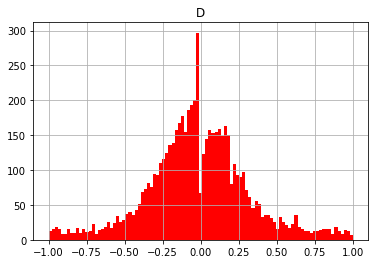

In [25]:
labelsdf.hist( column=['D'],bins=np.linspace(-1.0, 1.0, 100), color='red')

## Start Time

Another thing to look at here is the start time from the features file. The file has 4 slots for start times coming from the start counter, TOF, BCAL, and FCAL. It also has 4 slots containing a 0 or 1 that indicate whether each has a valid value. Ideally, all of the valid times will be passed in and the network will decide how to weight each one in inference. In reality, all of the times are not that easily available from the DTrackTimeBased object. Only the one it chose to use. Thus, only one of the slots is filled in. We plot up each of them though just to make sure they are reasonable values.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fa99aa93f28>],
      dtype=object)

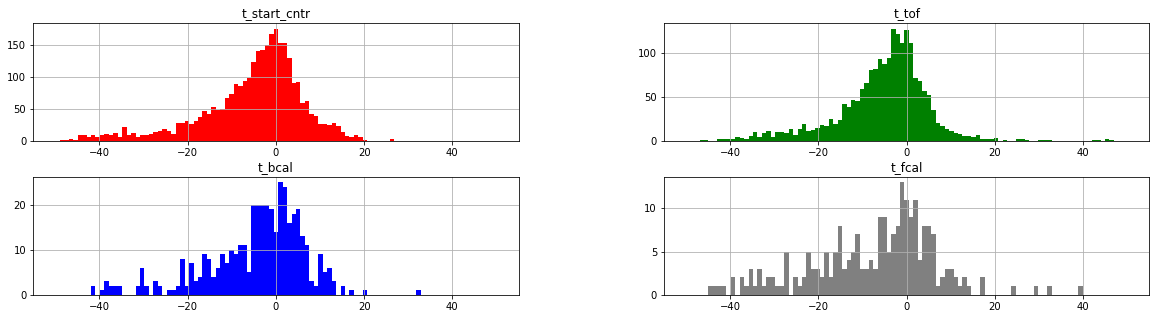

In [30]:
fig, ax = plt.subplots(2,2, figsize=(20,5))
df.hist(ax=ax[0,0], column=['t_start_cntr'],bins=np.linspace(-50.0, 50.0, 100), color='red')
df.hist(ax=ax[0,1], column=['t_tof'       ],bins=np.linspace(-50.0, 50.0, 100), color='green')
df.hist(ax=ax[1,0], column=['t_bcal'      ],bins=np.linspace(-50.0, 50.0, 100), color='blue')
df.hist(ax=ax[1,1], column=['t_fcal'      ],bins=np.linspace(-50.0, 50.0, 100), color='grey')

OK. So those don't look crazy. I'm not 100% sure what they should look like, but I would have guessed something peaked at zero and with a width less than 20ns. (Of course that is easy to say after I made the plots.) 